## Time to get your hands dirty. Galaxies vs quasars with neural networks.

Let's go back to our galaxy vs quasar data we've used in a previous exercise. 

1. Read in SDSS galaxy color data from `solutions/galaxyquasar.csv`. Create arrays for the $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create an array with the class labels where galaxy=$0$ and quasar=$1$. 

2. Now we're going to fit a neural network classifier. First, scale your data appropriately and do a 30% train/test split.

3. Now train the classifier. Use one the package among those we've seen. These include Tensorflow via keras, pytorch, and the MPL classifier implemented in scikit-learn. This is an opportunity to pick the one you're most interested in learning. 

3. Start from a network architecture with a single hidden layer with 5 neurons, using the `adam` solver, the `relu` activation function, and a learninig rate of `0.001`. Plot the resulting ROC curve. 

4. Now let's optimize the hyperparameters of your network. Explore different hyperparameters and see what fits the data best.  Do your best now to optimize the network architecture. Be creative!

5. Is your best result comparable with the simpler classifiers we've seen before? Do we need deep learning here? If yes, which features are captured best?

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from astropy.visualization.hist import hist as fancyhist
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
%load_ext tensorboard
from tensorboard.plugins.hparams import api as hp

In [2]:
#Loading the data
df_quasar = pd.read_csv("../../solutions/galaxyquasar.csv")
df_quasar

,u,g,r,i,z,class,z1,zerr
0,18.97213,18.53676,18.58280,18.34936,18.29215,QSO,0.522819,0.000155
1,19.24592,17.47646,16.47817,16.04472,15.68851,GALAXY,0.122846,0.000028
2,19.43536,17.70268,16.91565,16.58327,16.39128,GALAXY,0.000000,0.000000
3,19.31626,18.18312,17.39591,16.94549,16.65395,GALAXY,0.147435,0.000009
4,19.28828,19.11188,18.88937,18.80013,18.49183,QSO,2.011455,0.000631
...,...,...,...,...,...,...,...,...
49995,19.37295,18.12382,17.39886,16.98503,16.70585,GALAXY,0.113016,0.000011
49996,18.52021,16.88262,16.03280,15.56884,15.22454,GALAXY,0.085063,0.000014
49997,18.62718,17.30876,16.87371,16.62399,16.42296,GALAXY,0.054429,0.000008
49998,19.55140,18.27711,17.62101,17.21947,17.03347,GALAXY,0.112571,0.000009


In [3]:
name = df_quasar['class'].copy()

In [5]:
#Defining the vectors for different colors
u_g = np.array(df_quasar['u'] - df_quasar['g'])
g_r = np.array(df_quasar['g'] - df_quasar['r'])
r_i = np.array(df_quasar['r'] - df_quasar['i'])
i_z = np.array(df_quasar['i'] - df_quasar['z'])
class_labels = np.array(df_quasar['class'])

In [4]:
#Changing the labels
le = LabelEncoder()
df_quasar['class'] = le.fit_transform(df_quasar['class'])
labels = le.inverse_transform(df_quasar['class'])
class_names = le.classes_
print(class_names)

['GALAXY' 'QSO']


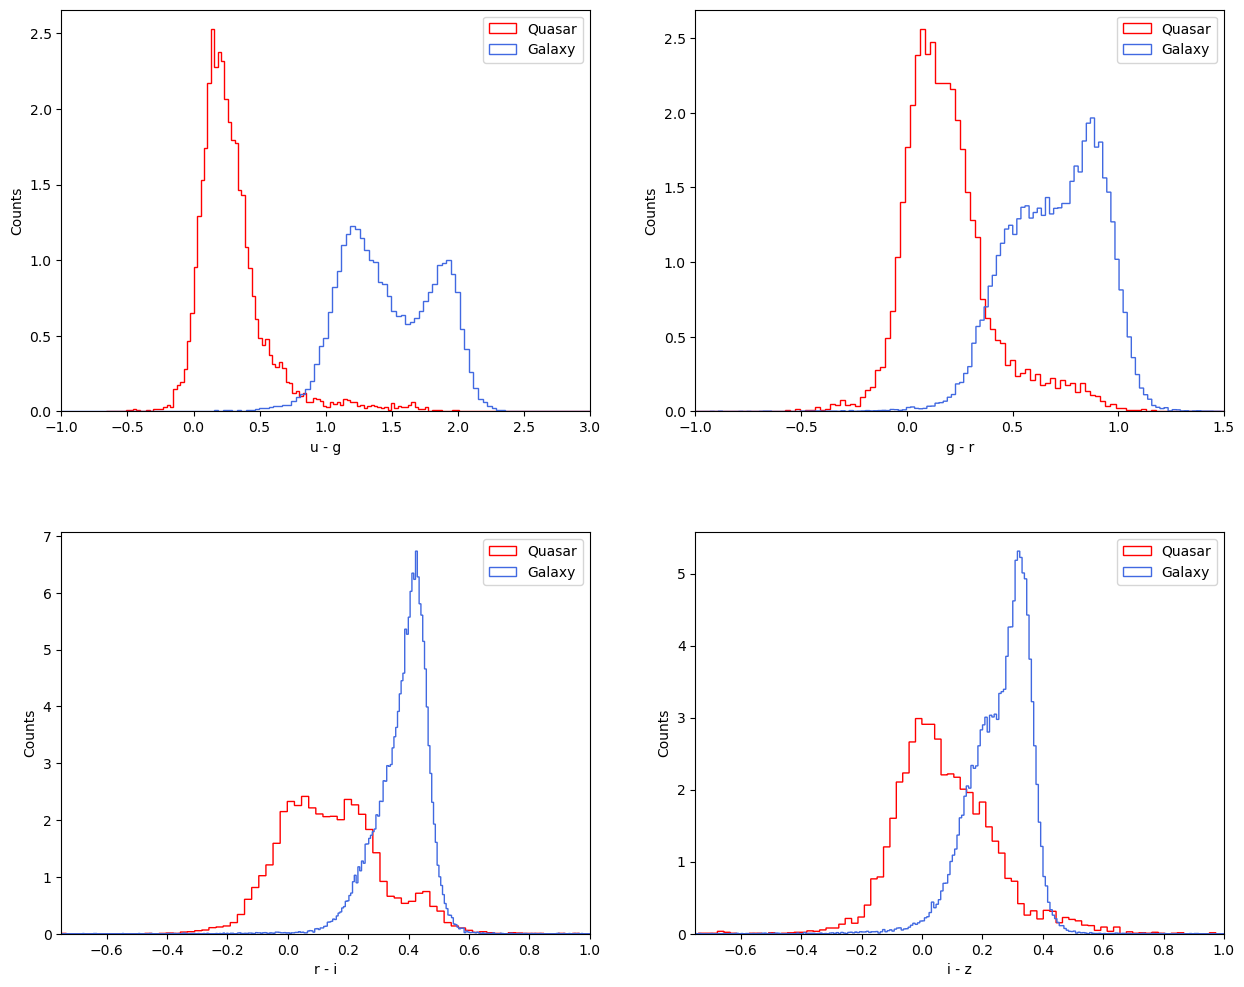

In [6]:
#Histogram of the colors
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

fancyhist(u_g[df_quasar['class']==1], bins="freedman", ax=axs[0,0], density=True, ec='red', histtype='step', label = 'Quasar')
fancyhist(u_g[df_quasar['class']==0], bins="freedman", ax=axs[0,0], density=True, ec='royalblue', histtype='step', label = 'Galaxy')
axs[0,0].set_xlabel('u - g')
axs[0,0].set_ylabel('Counts')
axs[0,0].set_xlim(-1, 3)
axs[0,0].legend()

fancyhist(g_r[df_quasar['class']==1], bins="freedman", ax=axs[0,1], density=True, ec='red', histtype='step', label = 'Quasar')
fancyhist(g_r[df_quasar['class']==0], bins="freedman", ax=axs[0,1], density=True, ec='royalblue', histtype='step', label = 'Galaxy')
axs[0,1].set_xlabel('g - r')
axs[0,1].set_ylabel('Counts')
axs[0,1].set_xlim(-1, 1.5)
axs[0,1].legend()

fancyhist(r_i[df_quasar['class']==1], bins="freedman", ax=axs[1,0], density=True, ec='red', histtype='step', label = 'Quasar')
fancyhist(r_i[df_quasar['class']==0], bins="freedman", ax=axs[1,0], density=True, ec='royalblue', histtype='step', label = 'Galaxy')
axs[1,0].set_xlabel('r - i')
axs[1,0].set_ylabel('Counts')
axs[1,0].set_xlim(-0.75, 1)
axs[1,0].legend()

fancyhist(i_z[df_quasar['class']==1], bins="freedman", ax=axs[1,1], density=True, ec='red', histtype='step', label = 'Quasar')
fancyhist(i_z[df_quasar['class']==0], bins="freedman", ax=axs[1,1], density=True, ec='royalblue', histtype='step', label = 'Galaxy')
axs[1,1].set_xlabel('i - z')
axs[1,1].set_ylabel('Counts')
axs[1,1].set_xlim(-0.75, 1)
axs[1,1].legend()

plt.subplots_adjust(hspace=0.3)
plt.show()

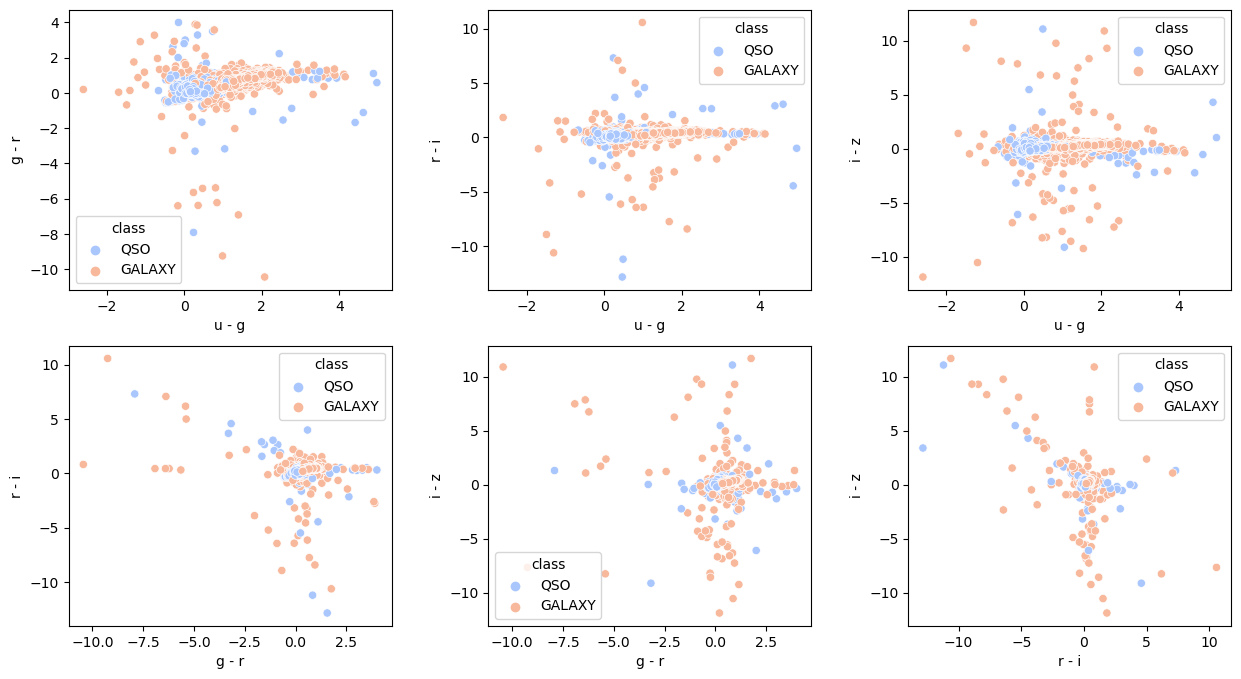

In [7]:
#Scatter plot of all the couples of colors
color = pd.DataFrame({'u - g': u_g, 'g - r': g_r, 'r - i': r_i, 'i - z': i_z})

fig, axs = plt.subplots(2, 3, figsize=(15, 8))

sns.scatterplot(data=color, x='u - g', y='g - r', hue=name, ax = axs[0,0], palette='coolwarm')
sns.scatterplot(data=color, x='u - g', y='r - i', hue=name, ax = axs[0,1], palette='coolwarm')
sns.scatterplot(data=color, x='u - g', y='i - z', hue=name, ax = axs[0,2], palette='coolwarm')
sns.scatterplot(data=color, x='g - r', y='r - i', hue=name, ax = axs[1,0], palette='coolwarm')
sns.scatterplot(data=color, x='g - r', y='i - z', hue=name, ax = axs[1,1], palette='coolwarm')
sns.scatterplot(data=color, x='r - i', y='i - z', hue=name, ax = axs[1,2], palette='coolwarm')

plt.subplots_adjust(wspace=0.3)
plt.show()

In [8]:
#Scaling the data
scaler = StandardScaler().set_output(transform="pandas")
data_scaled = scaler.fit_transform(color)

#Splitting the data into a train set and a test set
X_train, X_test, y_train, y_test = train_test_split(data_scaled.to_numpy(), class_labels, test_size=0.3, random_state=42)

## Simpliest model

In [9]:
#Defining a very simple NN
model = tf.keras.Sequential([
    tf.keras.Input(shape=(4,)),  #Input layer with 4 dimensions
    tf.keras.layers.Dense(units=5, activation='relu'),  #1 hidden layer with 5 neurons that use a ReLU activation function
    tf.keras.layers.Dense(units=1)  #Output layer with 1 dimension
    ])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 5)              │            25 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31 (124.00 B)

 Trainable params: 31 (124.00 B)

 Non-trainable params: 0 (0.00 B)

I make use of the Binary Crossentropy as loss function. Is typically used for binary classification problems.

It is defined as:
$$ BC = - \frac{1}{N} \sum_{i=1}^{N} \left[ y_i \log(p_i) + (1 - y_i) \log(1 - p_i) \right]; $$
where $N$ is the number of samples, $y_i$ is the class label (0,1) and $p_i$ is the probability that a data point belongs to the class $i$.

I also make use of the Adam optimizer and I run the NN for 10 epochs.

In [10]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
model.fit(X_train, y_train, validation_split=0.3, epochs=10)

Epoch 1/10
766/766 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9241 - loss: 0.2304 - val_accuracy: 0.9819 - val_loss: 0.1619
Epoch 2/10
766/766 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9819 - loss: 0.1407 - val_accuracy: 0.9836 - val_loss: 0.1501
Epoch 3/10
766/766 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9840 - loss: 0.1330 - val_accuracy: 0.9831 - val_loss: 0.1291
Epoch 4/10
766/766 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9832 - loss: 0.1196 - val_accuracy: 0.9845 - val_loss: 0.1232
Epoch 5/10
766/766 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9824 - loss: 0.1244 - val_accuracy: 0.9843 - val_loss: 0.1167
Epoch 6/10
766/766 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9825 - loss: 0.1113 - val_accuracy: 0.9848 - val_loss: 0.1135
Epoch 7/10
766/766 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9837 - loss: 0.1081 - val_accuracy: 0.9849 - val_loss: 0.1085
Epoch 8/10
766/766 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9836 - loss: 0.0986 - val_accuracy: 0.

In [12]:
y_prob = model.predict(X_test)  #Computing the probabilities 

469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


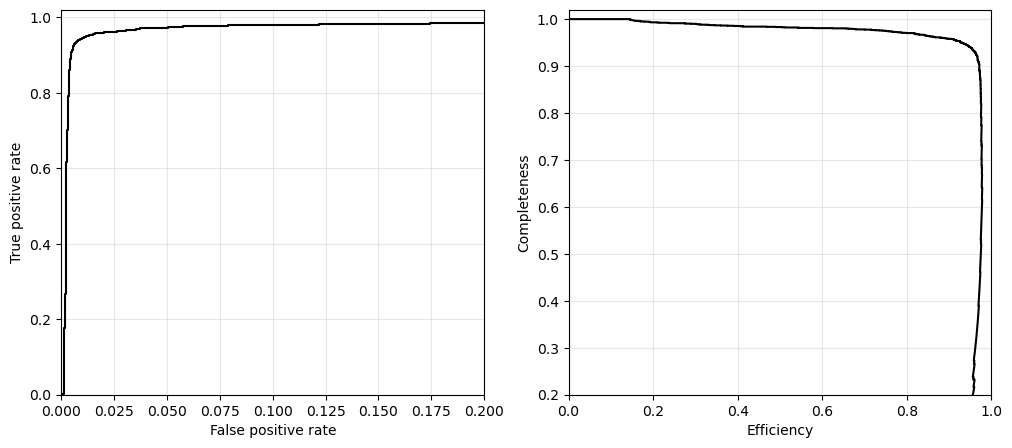

In [29]:
#Computing and plotting the ROC curves
fpr, tpr, thresh = roc_curve(y_test, y_prob)
precision, recall, thresh2 = precision_recall_curve(y_test, y_prob)
fpr = np.concatenate([[0], fpr])
tpr = np.concatenate([[0], tpr])
# Here we add (1,0) 
precision = np.concatenate([[0], precision])
recall = np.concatenate([[1], recall])
thresh2 = np.concatenate([[0], thresh2])

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(fpr, tpr, color = 'black')
axs[0].set_xlabel('False positive rate')
axs[0].set_ylabel('True positive rate')
axs[0].set_xlim(0, 0.2)
axs[0].set_ylim(0, 1.02)
axs[0].grid(alpha=0.3)

axs[1].plot(precision, recall, color = 'black')
axs[1].set_xlabel('Efficiency')
axs[1].set_ylabel('Completeness')
axs[1].set_xlim(0, 1.0)
axs[1].set_ylim(0.2, 1.02)
axs[1].grid(alpha=0.3)

plt.show()

In [14]:
#Printing the confusion matrix
print('Confusion matrix:\n', confusion_matrix(y_test, y_prob>0.5))

Confusion matrix:
 [[12704   108]
 [  133  2055]]


Already this simple model does a good job.

## Tensorboard

I will use tensorboard to tune the hyperparameter

In [52]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([10, 15, 20]))  #Possible values for the number of neurons in each hidden layer
HP_DROPOUT = hp.HParam('dropout', hp.Discrete([0.1, 0.3, 0.5]))  #Possible values for the rate of dropout

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_DROPOUT],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

In [53]:
def train_test_model(hparams):
  model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(4,)),
    tf.keras.layers.Dense(hparams[HP_NUM_UNITS], activation='sigmoid'),  #1 hidden layer with a sigmoid activation function
    tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
    tf.keras.layers.Dense(1, activation='sigmoid'),  #Also in the output layer I used the sigmoid activation function
  ])
  model.compile(
      optimizer='adam',
      loss=tf.keras.losses.BinaryCrossentropy(),
      metrics=['accuracy'],
  )

  model.fit(X_train, y_train, epochs=5)
  _, accuracy = model.evaluate(X_test, y_test)
  return accuracy

In [54]:
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = train_test_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [55]:
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
  for dropout_rate in HP_DROPOUT.domain.values:
      hparams = {
          HP_NUM_UNITS: num_units,
          HP_DROPOUT: dropout_rate,
      }
      run_name = "run-%d" % session_num
      print('--- Starting trial: %s' % run_name)
      print({h.name: hparams[h] for h in hparams})
      run('logs/hparam_tuning/' + run_name, hparams)
      session_num += 1

--- Starting trial: run-0
{'num_units': 10, 'dropout': 0.1}
Epoch 1/5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6884 - loss: 0.5402
Epoch 2/5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9665 - loss: 0.1669
Epoch 3/5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9778 - loss: 0.1133
Epoch 4/5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9798 - loss: 0.0883
Epoch 5/5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9824 - loss: 0.0804
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9826 - loss: 0.0753
--- Starting trial: run-1
{'num_units': 10, 'dropout': 0.3}
Epoch 1/5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8671 - loss: 0.3501
Epoch 2/5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9555 - loss: 0.1594
Epoch 3/5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9702 - loss: 0.1188
Epoch 4/5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9750 - loss: 0.1027
Epoch 5/5
1094/1094 ━━

In [57]:
#Looking at the accuracies it seems like the best hyperparameter are:
best_units = 10
best_dropout = 0.3

## Optimized model

In [58]:
opt_model = tf.keras.Sequential([
    tf.keras.Input(shape=(4,)),
    tf.keras.layers.Dense(units=best_units, activation='sigmoid'),
    tf.keras.layers.Dropout(best_dropout),
    tf.keras.layers.Dense(1, activation='sigmoid'),
    ])
opt_model.summary()

Model: "sequential_158"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_316 (Dense)               │ (None, 10)             │            50 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_157 (Dropout)           │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_317 (Dense)               │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61 (244.00 B)

 Trainable params: 61 (244.00 B)

 Non-trainable params: 0 (0.00 B)

In [59]:
opt_model.compile(loss = tf.keras.losses.BinaryCrossentropy(), optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
opt_model.fit(X_train, y_train, validation_split=0.3, epochs=20)

Epoch 1/20
766/766 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8798 - loss: 0.3281 - val_accuracy: 0.9610 - val_loss: 0.1780
Epoch 2/20
766/766 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9408 - loss: 0.1908 - val_accuracy: 0.9757 - val_loss: 0.1301
Epoch 3/20
766/766 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9612 - loss: 0.1448 - val_accuracy: 0.9794 - val_loss: 0.1017
Epoch 4/20
766/766 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9680 - loss: 0.1271 - val_accuracy: 0.9813 - val_loss: 0.0859
Epoch 5/20
766/766 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9702 - loss: 0.1123 - val_accuracy: 0.9822 - val_loss: 0.0778
Epoch 6/20
766/766 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9758 - loss: 0.0982 - val_accuracy: 0.9830 - val_loss: 0.0733
Epoch 7/20
766/766 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9756 - loss: 0.0973 - val_accuracy: 0.9833 - val_loss: 0.0708
Epoch 8/20
766/766 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9773 - loss: 0.0959 - val_accuracy: 0.

In [60]:
y_prob_opt = opt_model.predict(X_test)  #Computing the probabilities

469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


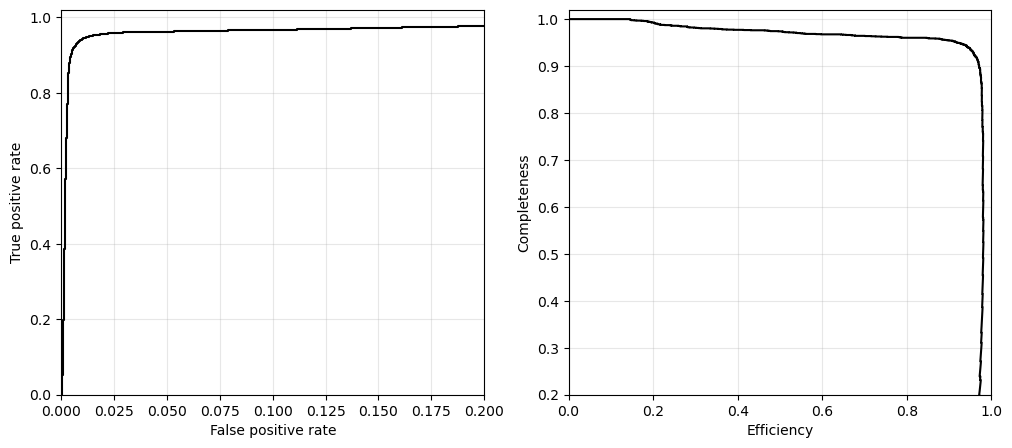

In [61]:
#Plotting the ROC curves
fpr_opt, tpr_opt, thresh_opt = roc_curve(y_test, y_prob_opt)
precision_opt, recall_opt, thresh2_opt = precision_recall_curve(y_test, y_prob_opt)
fpr_opt = np.concatenate([[0], fpr_opt])
tpr_opt = np.concatenate([[0], tpr_opt])
# Here we add (1,0) 
precision_opt = np.concatenate([[0], precision_opt])
recall_opt = np.concatenate([[1], recall_opt])
thresh2_opt = np.concatenate([[0], thresh2_opt])

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(fpr_opt, tpr_opt, color = 'black')
axs[0].set_xlabel('False positive rate')
axs[0].set_ylabel('True positive rate')
axs[0].set_xlim(0, 0.2)
axs[0].set_ylim(0, 1.02)
axs[0].grid(alpha=0.3)

axs[1].plot(precision_opt, recall_opt, color = 'black')
axs[1].set_xlabel('Efficiency')
axs[1].set_ylabel('Completeness')
axs[1].set_xlim(0, 1.0)
axs[1].set_ylim(0.2, 1.02)
axs[1].grid(alpha=0.3)

plt.show()

In [62]:
print('Confusion matrix:\n', confusion_matrix(y_test, y_prob_opt>0.5))

Confusion matrix:
 [[12705   107]
 [  141  2047]]


The performance of the optimized model is very similar to the performance of the simplest model. The optimization of a NN is very complicated. Actually, the first hyperparametr that one should try to optimize is the learning rate.